FileNotFoundError: [Errno 2] No such file or directory: '../../plots/Acrobot-v1 seed: 0.jpg'

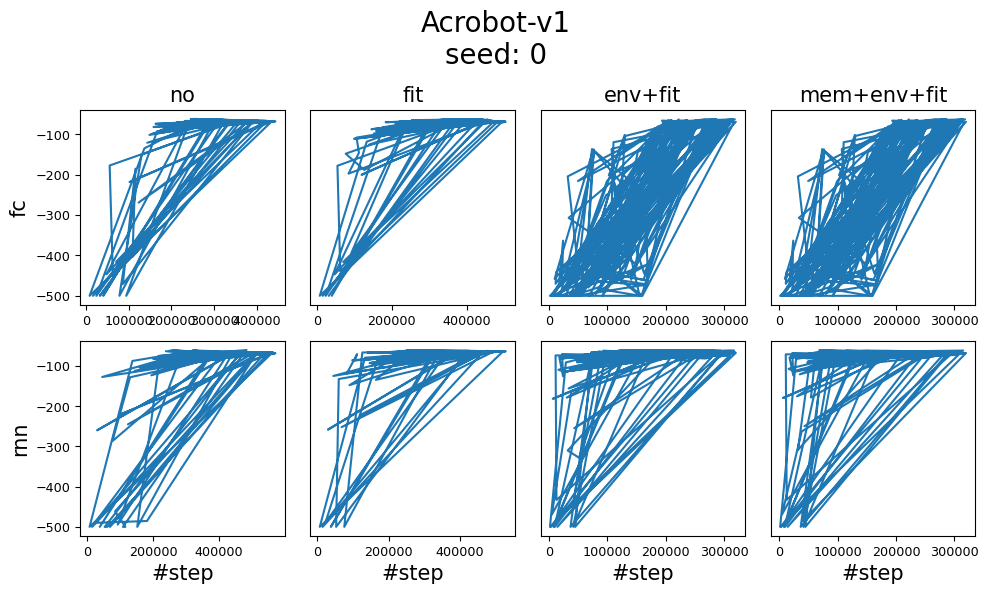

In [9]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from gran.utils.control import get_control_task_name
import matplotlib
import sys

sys.path.append('/gran/gran/rands/')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 9.2}
matplotlib.rc('font', **font)

plt.rc('figure', figsize = [10, 6])
plt.rc('figure', titlesize = 20)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=15)


def plot_results(exp_dict, save=False):
    for task in exp_dict.keys():
        for seed in exp_dict[task].keys():
            fig = plt.figure()
            i = 1
            for net in ['fc', 'rnn']:
                for transfer in ['no', 'fit', 'env+fit', 'mem+env+fit']:
                    res = exp_dict[task][seed][transfer][net]
                    axs = plt.subplot(2, 4, i)
                    for pop in range(len(res)):
                        gen = np.asarray(res[pop][1], dtype=int)
                        idx = np.argsort(gen)
                        steps = np.asarray(res[pop][2])[idx]
                        best = res[pop][3][idx]
                        mean = res[pop][4][idx]
                        plt.plot(steps, best, label=res[pop][0] + ' best')
                        # plt.plot(cum_steps, mean, label=res[pop][0] + ' mean')
                        # plt.legend()

                    if i <= 4:
                        axs.set_title(transfer)
                    else:
                        axs.set_xlabel('#step')
                    if i == 1 or i == 5:
                        axs.set_ylabel(net)
                    else:
                        axs.set_yticks([])
                    i += 1

            title = get_control_task_name(task)
            subtitle = f"seed: {seed}"
            fig.suptitle(title + '\n' + subtitle)
            plt.tight_layout()
            if save:
                plt.savefig("../../plots/" + title + " " + subtitle + ".jpg")
            plt.show()
            plt.close()


path = 'gran/data/states/envs.multistep.score.control'

experiments = os.listdir(path)
exp_dict = {}
for exp in experiments:
    exp_args = exp.split('~')
    task = exp_args[2].split('.')[1]
    seed = exp_args[0].split('.')[1]
    transfer = exp_args[3].split('.')[1]
    if exp_dict.get(task) is None:
        exp_dict[task] = {}
    if exp_dict[task].get(seed) is None:
        exp_dict[task][seed] = {}
    if exp_dict[task][seed].get(transfer) is None:
        exp_dict[task][seed][transfer] = {}

    nns = os.listdir(os.path.join(path, exp))
    for nn in nns:
        net = nn.split('.')[-2]
        exp_dict[task][seed][transfer][net] = []

        if net == "rnn":
            from gran.rands.bots.network.static.rnn.control import Bot
        else:  # 'static.fc' in bots_path:
            from gran.rands.bots.network.static.fc.control import Bot

        pops = os.listdir(os.path.join(path, exp, nn))
        for pop in pops:
            gens = os.listdir(os.path.join(path, exp, nn, pop))
            scores = []
            steps = []
            for gen in reversed(gens):
                # scores (pop // 2, nb_tests)
                scores.append(np.load(os.path.join(path, exp, nn, pop, gen, 'scores.npy')))

                with open(os.path.join(path, exp, nn, pop, gen, 'state.pkl'), "rb") as f:
                    state = pickle.load(f)
                    _, _, nb_steps = state
                f.close()
                steps.append(nb_steps)

            scores = np.stack(scores)  # (gens, pop // 2, nb_tests)
            avg_tests_score = np.mean(scores, axis=-1)  # (gens, pop // 2)
            best_individual = np.max(avg_tests_score, axis=-1)  # (gens,)
            mean_individual = np.mean(avg_tests_score, axis=-1)  # (gens,)

            exp_dict[task][seed][transfer][net].append([pop, gens, steps, best_individual, mean_individual])

plot_results(exp_dict, save=False)




acrobot 16 x 200 x -100
cart_pole 16 x 300 x 475
mountain_car 64 x 1000 x -110
mountain_car_continuous 32 x 500 x 90
lunar_lander 64 x 3000 x 200
lunar_lander_continuous 64 x 2000 x 200

# 